# "Physics-based" learning from equations: PINNs

This notebook is an introduction to regression problems that are found when dealing with partial differential equations (PDE) derived for (geo)physical systems. In particular, we will explore a general method that informs the machine learning model about the underlying governing equations we are trying to solve.

## 1. Introduction
### 1.1 Objectives

**The goal of this notebook is to learn about physics-informed approaches and how they are implemented in practice. The student will be encouraged in particular, to play with the physics-based loss function to solve different sets of equations.**

Physics-Informed Neural Networks (abbreviated PINNs) were first introduced in 2017 by [Raissi et al.](https://doi.org/10.1016/j.jcp.2018.10.045) as a "data-efficient universal function approximators that naturally encode any underlying physical laws as prior information". First, this means that PINNs can be used as drop-in remplacement to classical numerical solvers such as finite differences, finite volumes or spectral methods. Then, the concept of PINNs is also built on the important universal approximation theorem, which states that there always exists an architecture that approximates the target function to a certain precision. Finally, the success of PINNs also comes from their simplicity and the low (or even non-existent) data requirements. To be more precise, a PINN with parameters $\lambda$ can predict non-linear partial differential operators $\mathcal{N}(u, \lambda)$ that solves equations of the form

$$ u_{t} + \mathcal{N}(u, \lambda) = 0 $$

### 1.2. Differentiable programming (or automatic differentiation)

The algorithms explored in this notebook can be implemented with any differentiable programming framework, i.e., any library that offers automatic differentiation capabilities. Automatic differentiation can be used to evaluate any partial derivative

$$ \frac{\partial u}{\partial x}\biggr|_v $$

numerically at $v$. It differs from symbolic differentiation in that it does not give a mathematical expression but a numerical value. It also differs from numerical differentiation via e.g., finite differences in that it evaluates the exact derivative and not an approximation.

In fact, automatic differentiation is the building block of backpropagation, the algorithm used by any machine learning framework which estimates the gradient (or sensitivity) of the neural network with respect to its trainable parameters.

### 1.3. Imports and configuration

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp

import models

> *Note*: We will use the Python library JAX for this tutorial. It has a similar interface than NumPy, i.e. you call `jnp.` instead of `np.`, but the functions can run on any hardware (CPUs, GPUs and TPUs). JAX also offers some program transformation capabilities that are described with some experiments in Supplement 1 (S1) at the end of this notebook.

## 2. Physics-Informed Neural Networks

### 2.1 A priori known information about the PDE: initial and boundary conditions

Recall that when training a PINN, we need to constrain the learning with known information about the PDE. These constraints come as individual loss functions:
* $L_{\mathrm{eq}}$ is the loss on the equation residual.
* $L_{\mathrm{IC}}$ is the loss on the initial condition.
* $L_{\mathrm{BC}}$ is the loss on the boundary conditions.

and the total loss $L$ used to optimize the model takes these three into account:

$$ L = L_{\mathrm{eq}} + L_{\mathrm{IC}} + L_{\mathrm{BC}}. $$

As a demonstration, we will start with a one-dimensional [Burgers' equation](https://en.wikipedia.org/wiki/Burgers%27_equation), a non-linear time-dependent PDE. Burgers' equation reads

$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} \quad  \forall (t,x) \in [0,T] \times \mathcal{X}, $$

where $\nu$ is the diffusivity, $[0,T]$ is the time domain and $\mathcal{X}$ is the 1D spatial domain to be defined below. 
The goal of the PINN here will be to produce an approximation of $u$ given time $t$ and spatial position $x$. We will train a neural network (model) $\mathrm{NN}$ such that $\mathrm{NN}(t, x) \approx u(t, x)$.

**2.1.1. Initial conditions**

Let us start with the initial condition,

$$ u(t=0, x) = f(x). $$

In [2]:
def ic(x):
  """ Initial conditions of the system. """
  return jnp.exp(-x**2/2)

**2.1.2. Boundary conditions**

Now, we need a way to penalize the boundary conditions. We define the spatial domain  $\mathcal{X}$ as the open set $]a, b[$. We wish the solution to satisfy Dirichlet boundary conditions (BCs) at both ends of the domain: 

$$ u(t, x=a) = c_{a}, \quad u(t, x=b) = c_{b} \quad \forall t \in [0,T].$$

In order to penalize the Dirichlet BCs, we can substract the values $u_{\mathrm{pred}}$ predicted by the model with the expected values at the boundary. Note that the PINN automatically takes the mean squared error of the mismatch provided by the BC loss. If we take the difference of the predicted and exact boundary value, $L_{\mathrm{BC}}$ will be given as

$$ L_{\mathrm{BC}} = \frac{1}{\mathcal{X}} \sum_{x \in \mathcal{X}} (\mathrm{NN}(t, a) - c_a)^2 + (\mathrm{NN}(t, b) - c_b)^2 $$

*Remark*: It is important that the initial conditions also fulfil the boundary conditions, otherwise the problem is ill posed and learning might fail or give invalid results.

In [3]:
# Coordinates of the left and right boundaries
a = -2 * jnp.pi
b =  2 * jnp.pi

# Values for Dirichlet boundary conditions
c_a = 0
c_b = 0

def bc(upred_a, upred_b):
  """ Given NN predictions at boundaries a and b, measure the mismatch with exact boundary values. """
  return jnp.array([upred_a - c_a, upred_b - c_b])

**2.1.3. Equation residual**

The final part of the Physics-Informed loss function is the equation residual loss. Here, we use automatic-differentiation capabilities to write the partial derivatives exactly. With `JAX`, we use the function `jax.grad` for a quantity with respect to the argument indicated by the parameter `argnums`. For the partial derivative of $u$ with respect to time $t$, 

$$ \frac{\partial u(t, x)}{\partial t} $$

we write ``dudt = jax.grad(u, argnums=0)`` where `u` is a function that takes `t` and `x` as arguments (**in this specific order**). We can call `jax.grad` multiple times to obtain higher-order derivatives.

In [4]:
nu = 0.01
def eq(u_pred, t, x):
  """ u_pred is a callback to predict u(t, x) from using NN. """
  u = u_pred(t, x)
  u_t = jax.grad(u_pred, argnums=0)(t, x)
  u_x = jax.grad(u_pred, argnums=1)(t, x)
  u_xx = jax.grad(jax.grad(u_pred, argnums=1), argnums=1)(t, x)
  f = u_t + u * u_x - nu * u_xx
  return f

### 2.2 Setting and running the PINN learning problem

**2.2.1 Setting** 

We are now ready to create the PINN with random sampling. To set the PINN, we need to define the temporal horizon, here chosen to be $t \in [0, T]$ and the size of the spatio-temporal space we want to explore, i.e., the number of sample points $N_x$ and $N_t$ in the $x$ and $t$ dimensions, respectively.

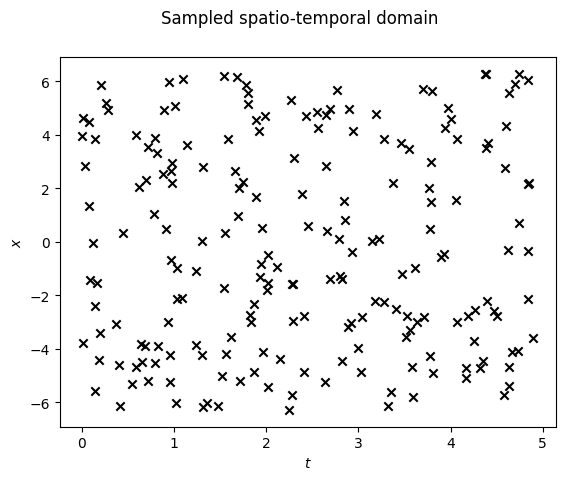

In [8]:
# End of the temporal horizon
T = 5.0

pinn = models.PhysicsInformed(
  N_x=200,
  N_t=200, # N_x and N_t must be the same 
  t_domain=(0, T),
  x_domain=(a, b),
)

t, x = pinn.sample_space_time()

fig, axs = plt.subplots()
axs.scatter(t, x, marker='x', c='k')
axs.set_xlabel(r'$t$')
axs.set_ylabel(r'$x$')
fig.suptitle(r'Sampled spatio-temporal domain')
plt.show()

**2.2.2 Training**

To train the model, we need to define a `backend`. The `backend` is the neural architecture $\mathrm{NN}$ with trainable parameters that will be used to predict $u$. Here, the architecture is required to take two features and predicts one, since we have one quantity of interest $u$ and two inputs $t$ and $x$. We have prepared a simple MultiLayer Perceptron (MLP) in the `models.py` file.

100%|██████████| 2000/2000 [14:45<00:00,  2.26it/s, loss=0.0013230832]                                                   


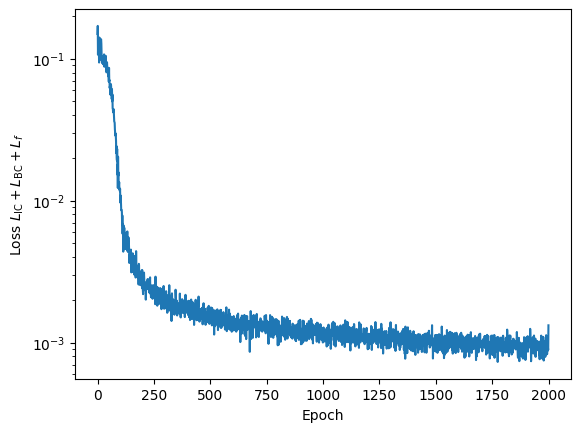

In [9]:
pinn.train(
  backend=models.MLP(n_blocks=9, features=20),
  ic_fn=ic,
  bc_fn=bc,
  eq_fn=eq,
  learning_rate=5e-4,
  epochs=2000
)

## 3. Evaluating

### 3.1. PINN: a compact **temporal** discretization

We can now explore the solution learned from our PINN. In classical numerical methods to solve differential equations, we need to advance the solution in time from the initial conditions, using for example Runge Kutta integrators. 

Here, the neural operator does not require any temporal integration scheme, and we can just predict the value of $u$ at any time $t$. Let us predict the solution $u$ at final time $T$:

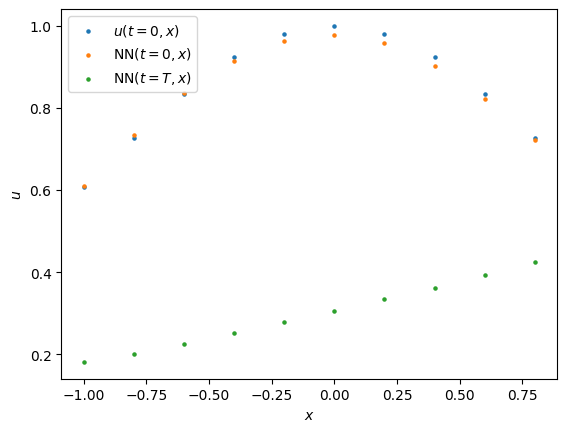

In [15]:
# True initial condition
u_0 = ic(x)

# Predict u using the trained PINN at time t=0 and t=T
u_nn = pinn.predict([0.0, T], x)

fig, axs = plt.subplots()
axs.scatter(x, u_0, s=5, label=r'$u(t = 0, x)$')
axs.scatter(x, u_nn[ 0], s=5, label=r'$\mathrm{NN}(t = 0, x)$')
axs.scatter(x, u_nn[-1], s=5, label=r'$\mathrm{NN}(t = T, x)$')
axs.set_xlabel(r'$x$')
axs.set_ylabel(r'$u$')
axs.legend()
plt.show()

### 3.2. PINN: a compact **spatial** discretization

In the previous predictions, we used the $N_x$ sampled spatial points, but again, a PINN can be used to predict the solution $u$ for any type of grid discretization, this allows arbitrary precision of the prediction. 

Here, we compare the output of the PINN with two predictions, on a coarse grid with 10 points and a finer grid with 500 points:

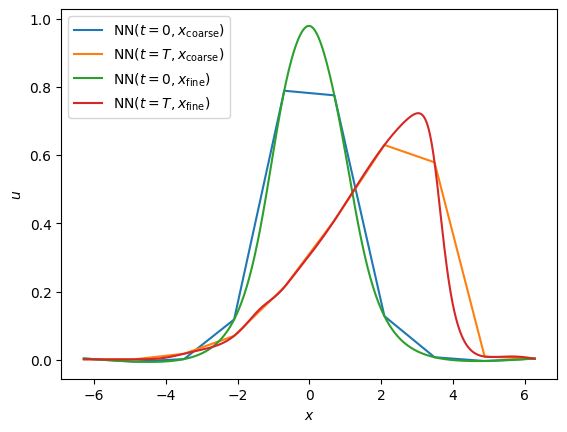

In [16]:
# Define a coarse equispaced grid with 10 points
x_coarse = jnp.linspace(a, b, 10)
# Define a fine equispaced grid with 500 points
x_fine = jnp.linspace(a, b, 500)

u_nn_coarse = pinn.predict([0.0, T], x_coarse)
u_nn_fine = pinn.predict([0.0, T], x_fine)

fig, axs = plt.subplots()
axs.plot(x_coarse, u_nn_coarse[ 0], label=r'$\mathrm{NN}(t = 0, x_{\mathrm{coarse}})$')
axs.plot(x_coarse, u_nn_coarse[-1], label=r'$\mathrm{NN}(t = T, x_{\mathrm{coarse}})$')
axs.plot(x_fine, u_nn_fine[ 0], label=r'$\mathrm{NN}(t = 0, x_{\mathrm{fine}})$')
axs.plot(x_fine, u_nn_fine[-1], label=r'$\mathrm{NN}(t = T, x_{\mathrm{fine}})$')
axs.set_xlabel(r'$x$')
axs.set_ylabel(r'$u$')
axs.legend()
plt.show()

### 3.3. A spatial-temporal neural solver

One can combine both predictions from 3.1. and 3.2. to produce a spatial-temporal prediction. Our PINN is a compact solver that approximates the prescribed equation with given initial and boundary conditions:

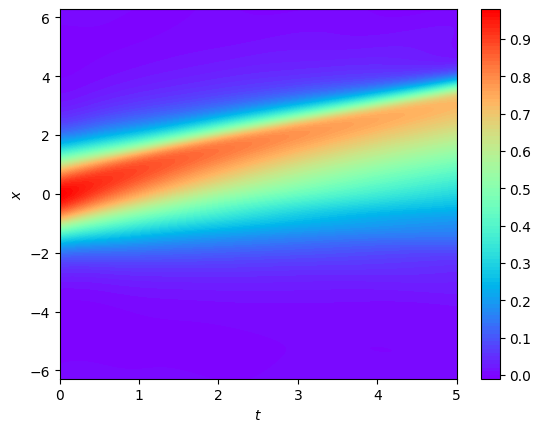

In [17]:
# Spatio-temporal equispaced discretization 
t_s = np.linspace(0, T, 200)
x_s = np.linspace(a, b, 200)

u_nn = pinn.predict(t_s, x_s)

fig, axs = plt.subplots()
fig.colorbar(axs.contourf(t_s, x_s, u_nn.T, levels=100, cmap='rainbow'), ax=axs)
axs.set_xlabel(r'$t$')
axs.set_ylabel(r'$x$')
plt.show()

## 3.4. Quantitative evaluation

A precise evaluation of the solver would consist in comparing its predictions with other, well evaluated numerical methods such as finite differences. This is beyond the scope of this tutorial. Instead, it is possible to have an idea of the PINN's precision by looking at the different loss functions. 

Here, we do not have here a clear separation between training and testing datasets, since training data were generated randomly. However, we can assume that the spatio-temporal discretization above ($N_x = N_t = 200$ equally spaced points) has not been seen during training.

Let us evaluate the three loss functions with the previous predictions:

In [18]:
def L_ic(u_nn_0):
  ic_exact = ic(x_s)
  return jnp.mean(jnp.square(u_nn_0 - ic_exact))

def L_bc(u_nn_a, u_nn_b):
  bc_mismatch = bc(u_nn_a, u_nn_b)
  return jnp.mean(jnp.square(bc_mismatch))

def L_eq():
  """ Get the residual by evaluating the equation `eq` at each (t, x) couples. """
  eq_residual = pinn.residual(t_s, x_s, eq)
  return jnp.mean(jnp.square(eq_residual))

print('Initial condition loss L_ic =',L_ic(u_nn[0]))
print('Boundary condition loss L_bc =',L_bc(u_nn[:, 0], u_nn[:, -1]))
print('Equation residual loss L_eq =',L_eq())

Initial condition loss L_ic = 8.300749e-05
Boundary condition loss L_bc = 4.2298648e-06
Equation residual loss L_eq = 0.0008211477


We can see that there is room for improvement, in particular for the equation residual. Just as for any numerical method, the precision of the PINN is also controllable. The accuracy of the solution can depend on the backend's number of degrees of freedom (given by the neural architecture), but also the size of the sampled space.

## 4. Experimenting

In order to experiment with PINNs, we propose the following exercises:

---

*Exercise 1* : Try to increase the number of epochs when training the PINN (from 2000 to 6000) and explore the new solutions. What do you observe?

*Exercise 2* : Use the trained PINN to predict a solution beyond the temporal horizon used during training (extrapolation), i.e., at $t > T$. Do you recognize some common limitations of NN?

*Exercise 3* : Experiment with a new set of initial conditions, boundary conditions and equations. For example, try to impose periodic boundary conditions. Also, try to learn a PINN for an other PDE of your choice (e.g. heat equation, wave equation, etc). If the solution is not satisfying, try changing the backend (in `models.py`).

### S.1 An introduction to JAX

[JAX](https://jax.readthedocs.io/en/latest/) is "a Python library for accelerator-oriented array computation and program transformation, designed for high-performance numerical computing and large-scale machine learning". Just as PyTorch and TensorFlow, JAX gives you automatic differentiation, via program transformation (**that can be composed**). We choose JAX for this notebook, because it has been designed specifically for scientific machine learning (understand here the application of machine learning to science applications, which is largely interested in differential equations). Remember that except for some small specificities, anything implemented in this notebook is also compatible with PyTorch and TensorFlow.

**S.1.1 The JAX-numpy interface**

JAX comes with an interface that reproduces as close as possible the one from `numpy` and `scipy`, except that the functions can be run on any hardware (CPU, GPU and TPU) and support different program transformation features. Here, we have imported `jax.numpy as jnp` and we can now use any classical `numpy` functions.

In [ ]:
zeros_numpy = np.zeros(10)
print(zeros_numpy)
zeros_jax = jnp.zeros(10)
print(zeros_jax)

**S.1.2 Just-in-time compilation**

JAX cares about speed. It is built around [XLA](https://github.com/openxla/xla), a compiler based on LLVM that performs many optimization to a given code, so that it runs faster on both CPUs and GPUs. In JAX, to transform a function using on-the-fly, or just-in-time (JIT), compilation, we can just call `jax.jit` on the corresponding function.

---

*Exercise 1* : Run the following code section, then try to reduce the size `N` of the array `x`. What do you observe? Can you comment on this behavior?

In [12]:
# Compute a gaussian using NumPy (note the np.)
def gaussian_numpy(x):
  return np.exp(-x**2)
# Compute a gaussian using JAX (note the jnp.)
def gaussian_jax(x):
  return jnp.exp(-x**2)

N = 1000000

x_numpy = np.linspace(-1.0, 1.0, N)
print('Gaussian evaluation time with NumPy (CPU): ', end='')
%timeit gaussian_numpy(x_numpy)

x_jax = jnp.linspace(-1.0, 1.0, N)
print('Gaussian evaluation time with JAX (GPU): ', end='')
%timeit gaussian_jax(x_jax)

# Now, transform the function with JIT compilation
gaussian_jax_jit = jax.jit(gaussian_jax)
# JIT compilation actually happens during the first call of the function
_ = gaussian_jax_jit(x_jax) 
print('Gaussian evaluation time with JAX-JIT (GPU): ', end='')
%timeit gaussian_jax_jit(x_jax).block_until_ready()

Gaussian evaluation time with NumPy (CPU): 5.96 ms ± 67 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Gaussian evaluation time with JAX (GPU): 952 µs ± 8.06 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Gaussian evaluation time with JAX-JIT (GPU): 502 µs ± 2.05 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


**S.1.3 Vectorization**

An other optimization that JAX proposes is vectorization, which enables running multiple operations at the same time, most of the time in parallel. This is particularly useful when using GPUs since data transfers are expensive. In JAX, to transform a function into a vectorized version, we can just call `jax.vmap` on the corresponding function. By default, it operates on the first axis of the given function arguments.

In [13]:
# Use gaussian_jax as if it was limited to scalar arguments
def naive_batch_gaussian(x):
  return jnp.stack([gaussian_jax(x_i) for x_i in x])

N = 500
x = jnp.linspace(-1.0, 1.0, 500)

print('Naive batch with Python for loop (slow): ', end='')
%timeit naive_batch_gaussian(x).block_until_ready()

print('Batch with JAX vectorization: ', end='')
%timeit jax.vmap(gaussian_jax)(x).block_until_ready()

Naive batch with Python for loop (slow): 44.1 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Batch with JAX vectorization: 621 µs ± 12 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


**S.1.4 Automatic differentiation (AD)**

Finally, and most importantly, we need automatic differentiation. In mathematical terms, taking derivatives of a multivariate function is equivalent to computing the gradient of the function. In JAX, to transform a function to obtain its gradient using AD, we can just call `jax.grad` on the corresponding function. Note that `jax.grad` only support scalar-valued functions.

---

*Exercise 2* : Run the following code section, then evaluate the gradiant of `gaussian_jax` at each point $x$ using `jax.vmap` vectorization.

*Exercise 3* : Compare the result of automatic differentiation with the exact Gaussian derivative $\frac{d}{dx} (\exp(-x^2)) = -2x \exp(-x^2)$ and the result from numerical differentiation with `jnp.gradient`.

In [14]:
def sum_gaussian(x):
  return jnp.sum(jnp.exp(-x**2))

x = jnp.linspace(-1.0, 1.0, 4)
print('Sum of the gaussians:',sum_gaussian(x))
# Transform the function with automatic differentiation
sum_gaussian_grad = jax.grad(sum_gaussian)
print('Gradient of the sum of gaussians with respect to x:',sum_gaussian_grad(x))

# Exercise 2
x = jnp.linspace(-1.0, 1.0, 10, endpoint=False)
derivative_gaussian_ad = jax.vmap(jax.grad(gaussian_jax))

def gaussian_derivative(x):
  return -2*x*jnp.exp(-x**2)

# Exercise 3
with jnp.printoptions(precision=2, suppress=True):
  print('Automatic differentiation:',derivative_gaussian_ad(x))
  print('Exact derivative         :',gaussian_derivative(x))
  print('Numerical derivative     :',jnp.gradient(gaussian_jax(x), 0.2))

Sum of the gaussians: 2.5254374
Gradient of the sum of gaussians with respect to x: [ 0.7357589   0.59655946 -0.5965596  -0.7357589 ]
Automatic differentiation: [ 0.74  0.84  0.84  0.68  0.38 -0.   -0.38 -0.68 -0.84 -0.84]
Exact derivative         : [ 0.74  0.84  0.84  0.68  0.38 -0.   -0.38 -0.68 -0.84 -0.84]
Numerical derivative     : [ 0.8   0.82  0.81  0.66  0.37  0.   -0.37 -0.66 -0.81 -0.85]
